## Organoid simulation (credit: Mason Hargrave, modif: Lucas Seninge)

This notebook is based on Mason's method to simulate organoids. It uses a stochastic model to determine which neurons will fire at t+1 based on neurons firing at t. See Mason's model description.

In [15]:
# Import modules
import numpy as np
np.random.seed(42)

Added inhibitory neurons to the total population: User can pick a proportion of inhibitory neurons which will be randomly picked in the neuron vector.

In the case of inhibitory neurons, neuron  $j$ firing at time  $t$ will cause neuron  $i$ to NOT fire at time  $t+1$. So we take the inverse of this probability so that in the product of $(1-p_{i,j})$ , inhibitory neurons firing will decrease the probability of neuron $i$ firing.

This simple model may need refinement as the biology of neuron inhibition is slightly different.

Also, we added a refractory period: if a neuron was firing at $t$, it won't be able to fire at $t+1$, no matter what the probability would have been.

## Model Initialization

In [58]:
# Simulation parameters
# Number of neurons
neurons = 1000

# Proportion of inhibitory neurons in the neuron population
prop_inhib = 0.2
# Generates seperate lists containing index values for excitatory inhibitory nuerons respectively
inhib_idx = np.random.choice(neurons, int(prop_inhib*neurons)) 
excitatory_idx = np.array(list(set(range(neurons))-set(inhib_idx)))

# Probability matrix - initialize randomly
probability_matrix = np.random.rand(neurons,neurons)

# Neurons state - initialize randomly
initial_state = np.random.randint(2, size=neurons)
# Number of iterations - discret time steps (change to actual time?)
time = 1000

In [59]:
# Preprocessing
# Scale-down probabilities by using index distance as a proxy for real distance
for (i,j) in np.ndindex(np.shape(probability_matrix)):
    distance = min(abs(i-j),neurons-abs(i-j)) #calculate toroidal distance (implementing periodic boundary conditions)
    # Avoid self firing for now
    if distance == 0:
        probability_matrix[i,j] = 0
    else:
        probability_matrix[i,j] = (1/distance**2) * probability_matrix[i,j]
        
print(probability_matrix)

[[0.         0.31528236 0.23826908 ... 0.01374994 0.1968479  0.25041318]
 [0.74170141 0.         0.2309739  ... 0.05043838 0.10662215 0.05119288]
 [0.03241115 0.22778475 0.         ... 0.01755822 0.01321858 0.04966249]
 ...
 [0.07130184 0.04764943 0.00657691 ... 0.         0.11845043 0.15836369]
 [0.08072867 0.06134441 0.03870313 ... 0.60184395 0.         0.54197415]
 [0.16621022 0.09174385 0.06577092 ... 0.2244122  0.39226869 0.        ]]


## Optimized version of next_state

In [63]:
def next_state(neurons, probability_matrix, previous_state):
    """
    Get new state t+1 of active/inactive neurons by using probabilities of firing.
    
    Args:
        neurons (int): number of neurons to be simulated.
        probability_matrix (np.array): probability of neuron j firing at t causing neuron i to fire at t+1.
        previous_state (np.array): vector of neuron states at t .
        
    Returns:
        next_state (np.array): vector of neuron states at t+1.
    """
    
    # Initialize values
    anti_probability_matrix = 1-(probability_matrix*previous_state)
    # Convert anti_probability_matrix into a masked array
    anti_probability_matrix = np.ma.array(anti_probability_matrix, mask = False)
    # Get probability of firing using numpy optimization
    # Mask inhibitory neurons to get normal product ie excitatory neurons contribution
    anti_probability_matrix.mask[:,inhib_idx] = True
    product = np.prod(anti_probability_matrix, axis=1)
    # Unmask inhibitory and get inverse of product for inhibitory contribution
    anti_probability_matrix.mask[:, inhib_idx] = False
    anti_probability_matrix.mask[:, excitatory_idx] = True
    # Compute expect values pi as 1-full product
    expectation_values = (1-product)*np.prod(anti_probability_matrix, axis=1)
    
    return (np.random.random(neurons) < expectation_values) #& (previous_state==0)

In [64]:
states= np.zeros((time+1, neurons))
states[0,:] = initial_state
for t in range(time):
    states[t+1,:] = next_state(neurons, probability_matrix, states[t,:])

Indices of inhibitory neurons: [728 610 726  47 297 511 781 244 673 421 863 553  95 605 918 805 478 373
 415 355 266 942 797 523 897 658 297 324 175 197 305 853 952 804 368 138
 620  25 166 512 233 150 547 618  33 738 451 758 357 869 782 231 635 422
 263 529 647 351 380 716 212 431 359 432 849  93 933 554 963 365 844 341
 161 986  90 619 713 942 970 869  15 995 350 787 519 327 489  26 713  84
 762 693 961 814 231 426 760 963 314 182 481 423 511 902 615 398  52 334
 398 576 647 430 252 353 820 167 934  45 309 294 755 907 951 196 678 526
 851 444 599 859 529 396  75 996 930 237 294 200 119  57 165 651 611 139
 655 393 115 681 983 370  18 841 459 669 441 526 263 943  65  22 216 325
 355  13 686 912 671 924 143 383 245 560 371 398 691 352 240 981 739 884
 367 514 993 400 138 811  63  56 538 609 373 518 770 375 143 157 606 880
 386  32]


Text(0.5,1,'Neuron Firings Over Time')

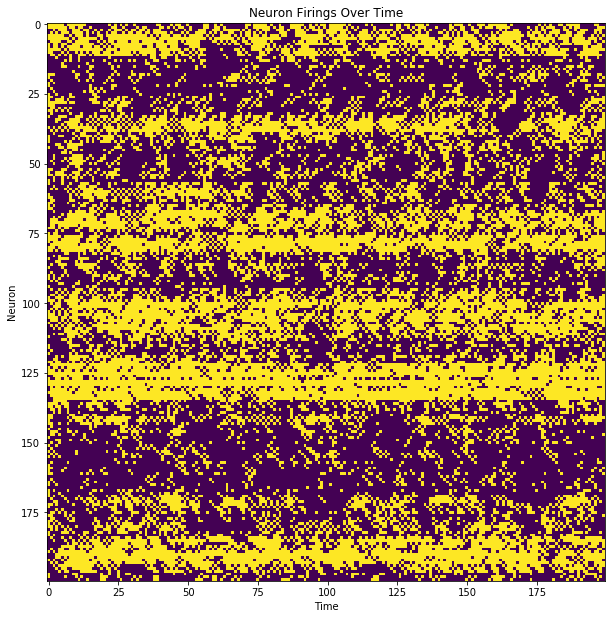

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,20))
plt.imshow(states.T[:200,:200])
plt.xlabel("Time")
plt.ylabel("Neuron")
plt.title("Neuron Firings Over Time")